In [ ]:
!pip install keras==2.15 tensorflow==2.15

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 7.8 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0
  Attempting uninstall: tensorboard
    Found existing installation

In [ ]:
import tensorflow as tf                                                               # библиотека Tensorflow
import keras                                                                          # библиотека Keras
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU, Rescaling     # cлои библиотеки Keras
from keras.layers import BatchNormalization, Conv2DTranspose, Concatenate             # cлои библиотеки Keras
from keras.layers import Rescaling, Resizing                                          # cлои библиотеки Keras
from keras.models import Model, Sequential                                            # конструкторы построения моделей библиотеки Keras

from keras.optimizers import Adam                                                     # оптимизатор Adam
from keras.preprocessing.image import  load_img                                       # загрузка изображений
from keras.utils import to_categorical                                                # преобразует вектор класса (целые числа) в двоичную матрицу класса

import random                                                                         # генератор случайных чисел

import numpy as np                                                                    # библиотека линейной алгебры
import pandas as pd                                                                   # библиотека обработки табличных данных
import os                                                                             # библиотека работы с функциями операционной системы, в том числе с файлами
import albumentations as A                                                            # библиотека аугментации изображений (https://albumentations.ai/)

import matplotlib.pyplot as plt                                                       # библиотека для рисования графиков
%matplotlib inline

In [ ]:
!pip install opendatasets
import opendatasets as op
op.download("https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kavreil
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database


100%|██████████| 778M/778M [00:06<00:00, 125MB/s]


In [ ]:
from pathlib import Path
dataset = Path("/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal")

In [ ]:
os.listdir(dataset)

['masks', 'images']

In [ ]:
from itertools import islice
images_dir = list(islice((dataset / "images").glob("*.png"), 1000))
masks_dir = list(islice((dataset / "masks").glob("*.png"), 1000))

In [ ]:
train_image_paths = [str(path) for path in images_dir[:900]]
train_mask_paths = [str(path) for path in masks_dir[:900]]

test_image_paths = [str(path) for path in images_dir[900:1000]]
test_mask_paths = [str(path) for path in masks_dir[900:1000]]

In [ ]:
image_paths = [str(path) for path in images_dir]
mask_paths = [str(path) for path in masks_dir]

Пришлось немного изменить код из примера, изображение приводим к float, а маску к int типу. Далее приводим изображение в тензор и прописываем кол-во каналов, аналогично с маской

In [ ]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0  # Нормализуем изображение

    # Приводим маску к целочисленному типу
    input_mask = tf.cast(input_mask, tf.int32)

    # Ограничиваем значения маски в диапазоне [0, num_classes - 1]
    num_classes = 3  # Укажите количество классов
    input_mask = tf.clip_by_value(input_mask, 0, num_classes - 1)

    return input_image, input_mask

In [ ]:
def load_image(image_path, mask_path):
    # Загружаем изображение
    input_image = tf.io.read_file(image_path)
    input_image = tf.image.decode_png(input_image, channels=3)
    input_image = tf.image.resize(input_image, (64, 64))

    # Загружаем маску
    input_mask = tf.io.read_file(mask_path)
    input_mask = tf.image.decode_png(input_mask, channels=1)
    input_mask = tf.image.resize(input_mask, (64, 64), method='nearest')

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

Здесь создаем два набора, тренировочный и тестовый

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths))
train_dataset = train_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(64).prefetch(1)

# Создаем тестовый датасет
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_paths, test_mask_paths))
test_dataset = test_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(8).prefetch(1)


In [ ]:
# Функция вывода изображений
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Изображение', 'Сегментирующая маска']             # определим заголовки графиков

  # В цикле выводим изображения из списка display_list
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)                    # выводим область для построения графика
    plt.title(title[i])                                       # выводим заголовок графика
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))  # преобразуем матрицу в изображение и выводим на экран
    plt.axis('off')                                           # отключаем отображение осей на графике
  plt.show()

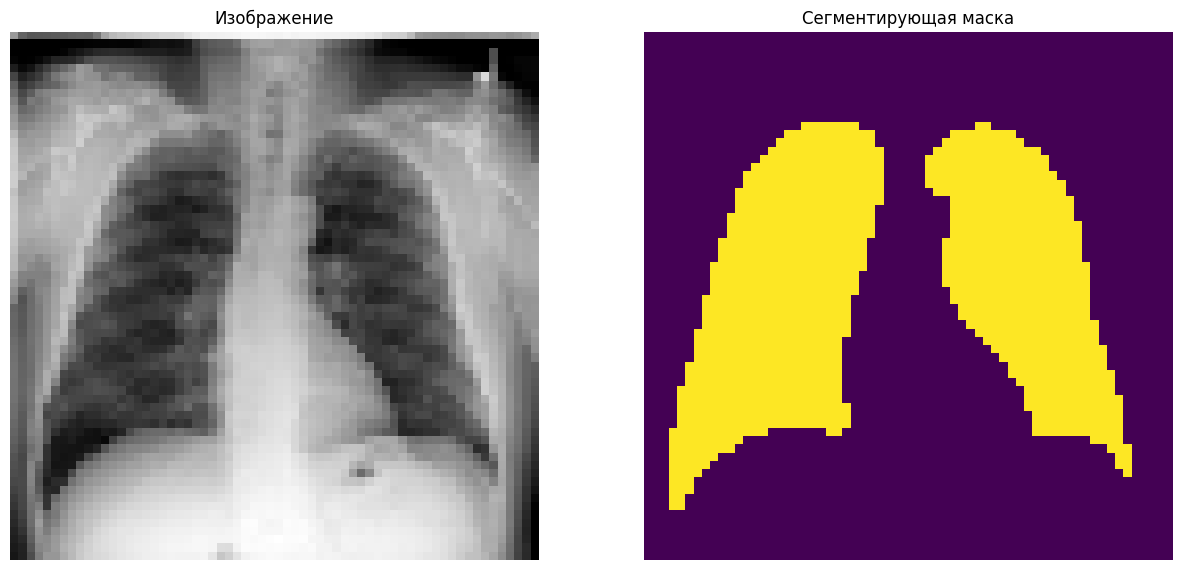

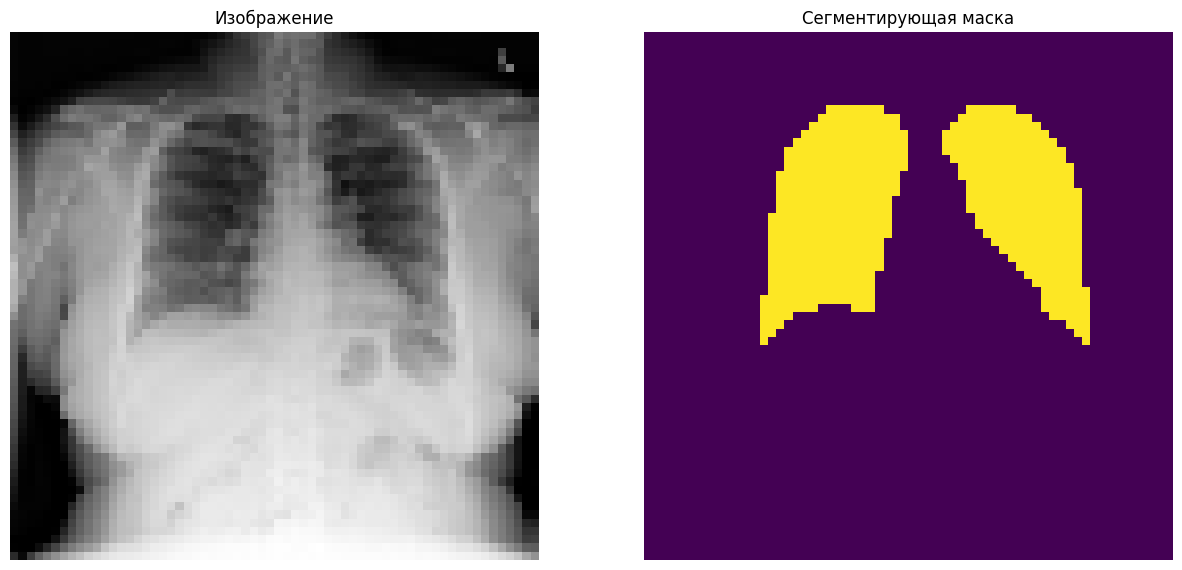

In [ ]:
for images, masks in train_dataset.take(2):                    # берем 2 экземпляра из пакета и выводим с помощью функции display на экран
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [ ]:
def convolution_operation(entered_input, filters=64):

    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    acti1 = ReLU()(batch_norm1)


    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(acti1)
    batch_norm2 = BatchNormalization()(conv2)
    acti2 = ReLU()(batch_norm2)

    return acti2

In [ ]:
# Функция кодировщика
# На входе 2 параметра - предыдущий слой и число фильтров (генерируемых карт признаков)
def encoder(entered_input, filters=64):

    encod1 = convolution_operation(entered_input, filters)  # функция свертки - 2 синих блока
    MaxPool1 = MaxPooling2D(strides = (2,2))(encod1)        # зеленый блок
    return encod1, MaxPool1 # функция возвращает латеральное соединение и выход из слоя

# Функция декодировщика
# На входе 3 параметра - предыдущий слой и латеральное соединение и число фильтров (генерируемых карт признаков)
def decoder(entered_input, skip, filters=64):
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input) # красный блок
    Connect_Skip = Concatenate()([Upsample, skip])                                        # белый блок (объединение латерального соединения и выхода предыдущего слоя)
    out = convolution_operation(Connect_Skip, filters)                                    # функция свертки - 2 синих блока
    return out # функция возвращает выход из слоя

In [ ]:
# Наша интерпретация модели U-net
def U_Net(img_size, num_classes):
    # Входной слой - желтый блок
    inputs = Input(img_size)

    # Задаем блоки кодировщика и латеральные соединения
    skip1, encoder_1 = encoder(inputs, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)

    # Бутылочное горлышка задаем 2-мя синими блоками
    conv_block = convolution_operation(encoder_4, 64*16)

    # Задаем блоки декодировщика и передаем ему латеральные соединения от кодировщиков
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)

    # Выходной слой (фиолетовый блок), его конфигурация зависит от решаемой задачи
    outputs = Conv2D(num_classes, kernel_size = (3, 3), padding="same", activation="softmax")(decoder_4)

    model = Model(inputs, outputs)
    return model

In [ ]:
num_classes = 3 # 3 класса: фон, сегментированый объект и рамка вокруг объекта
input_shape = (64, 64, 3) # размер к которому преобразуем изображение, 3 канала - RGB
model = U_Net(input_shape, num_classes) # инициализируем модель

In [ ]:
model.summary() # отчет о структуре модели

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 64)           1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 64, 64, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 64, 64, 64)           0         ['batch_normalization[0][0

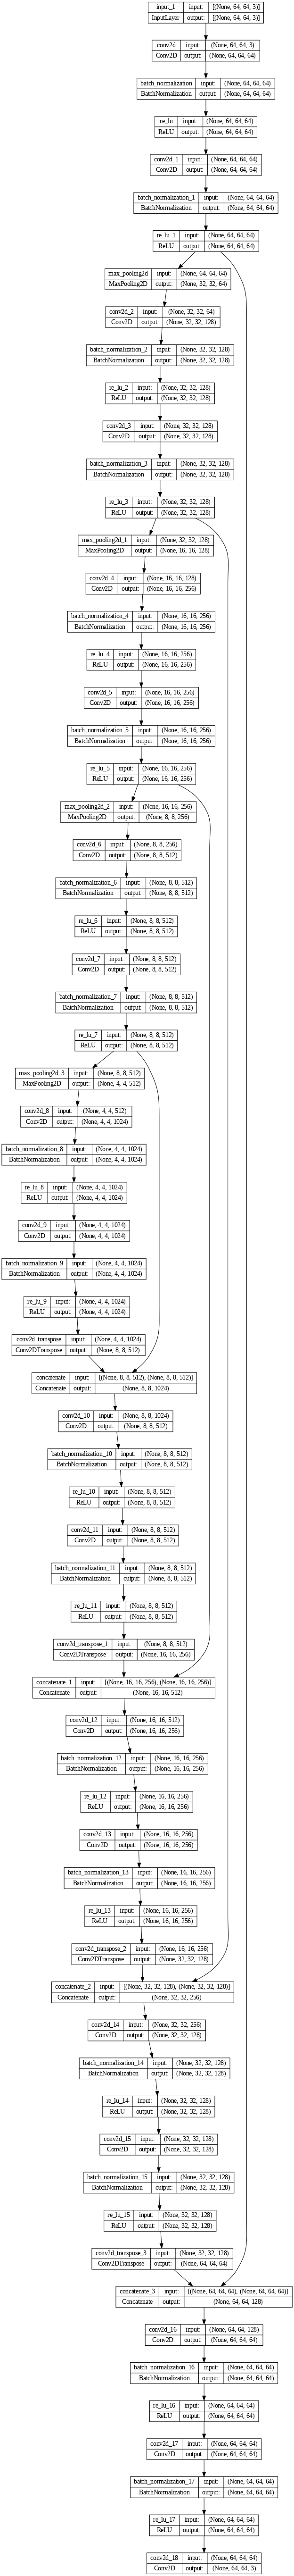

In [ ]:
# график структуры модели
tf.keras.utils.plot_model(model, "model.png", show_shapes=True, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=70)

In [ ]:
model.compile(
    optimizer=Adam() ,
    loss="sparse_categorical_crossentropy",
    metrics=['sparse_categorical_accuracy']
)

callbacks = [
    keras.callbacks.ModelCheckpoint("segmentation.keras", save_best_only=True)
]

In [ ]:
epochs = 15
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, callbacks=callbacks)

Epoch 1/15
15/15 [==============================] - 341s 22s/step - loss: 0.4029 - sparse_categorical_accuracy: 0.8429 - val_loss: 2.7749 - val_sparse_categorical_accuracy: 0.3906
Epoch 2/15
15/15 [==============================] - 341s 23s/step - loss: 0.0674 - sparse_categorical_accuracy: 0.9755 - val_loss: 7.0716 - val_sparse_categorical_accuracy: 0.3266
Epoch 3/15
15/15 [==============================] - 340s 23s/step - loss: 0.0430 - sparse_categorical_accuracy: 0.9837 - val_loss: 2.2362 - val_sparse_categorical_accuracy: 0.5332
Epoch 4/15
15/15 [==============================] - 343s 23s/step - loss: 0.0349 - sparse_categorical_accuracy: 0.9867 - val_loss: 0.9120 - val_sparse_categorical_accuracy: 0.7147
Epoch 5/15
15/15 [==============================] - 338s 22s/step - loss: 0.0295 - sparse_categorical_accuracy: 0.9886 - val_loss: 0.2819 - val_sparse_categorical_accuracy: 0.8964
Epoch 6/15
15/15 [==============================] - 344s 23s/step - loss: 0.0262 - sparse_categorica

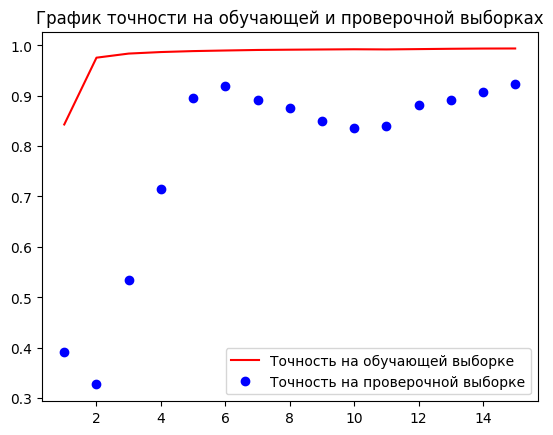

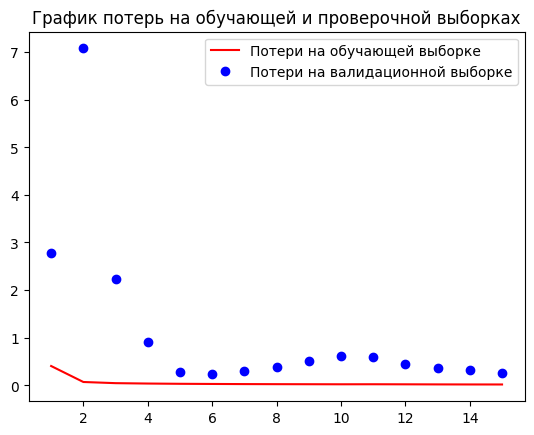

In [ ]:
acc = history.history['sparse_categorical_accuracy']                       # данные о точности на обучающей выборке
val_acc = history.history['val_sparse_categorical_accuracy']               # данные о точности на проверочной выборке
loss = history.history['loss']                                             # данные об ошибке на обучающей выборке
val_loss = history.history['val_loss']                                     # данные об ошибке на проверочной выборке
epochs = range(1, len(acc) + 1)                                            # массив со значениями для оси абсцисс (Х)
plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')          #  строим график точность на обучающей выборке
plt.plot(epochs, val_acc, 'bo', label='Точность на проверочной выборке')   #  строим график точность на проверочной выборке
plt.title('График точности на обучающей и проверочной выборках')           #  заголовок графика
plt.legend()                                                               #  легенда графика
plt.figure()                                                               #  создаем новую фигуру (полотно для графика)
plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')           #  строим график потерь (ошибки) на обучающей выборке
plt.plot(epochs, val_loss, 'bo', label='Потери на валидационной выборке')  #  строим график потерь на проверочной выборке
plt.title('График потерь на обучающей и проверочной выборках')             #  заголовок графика
plt.legend()                                                               #  легенда графика
plt.show()

In [ ]:
def display(display_list):
  plt.figure(figsize=(20, 20))

  title = ['Входное изображение', 'Оригинальная маска', 'Предсказанная маска']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[0]))            # отображаем картинку
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]),alpha=0.5)  # отображаем маску с прозрачностью 50%
    plt.axis('off')
  plt.show()

1/1 [==============================] - 0s 102ms/step


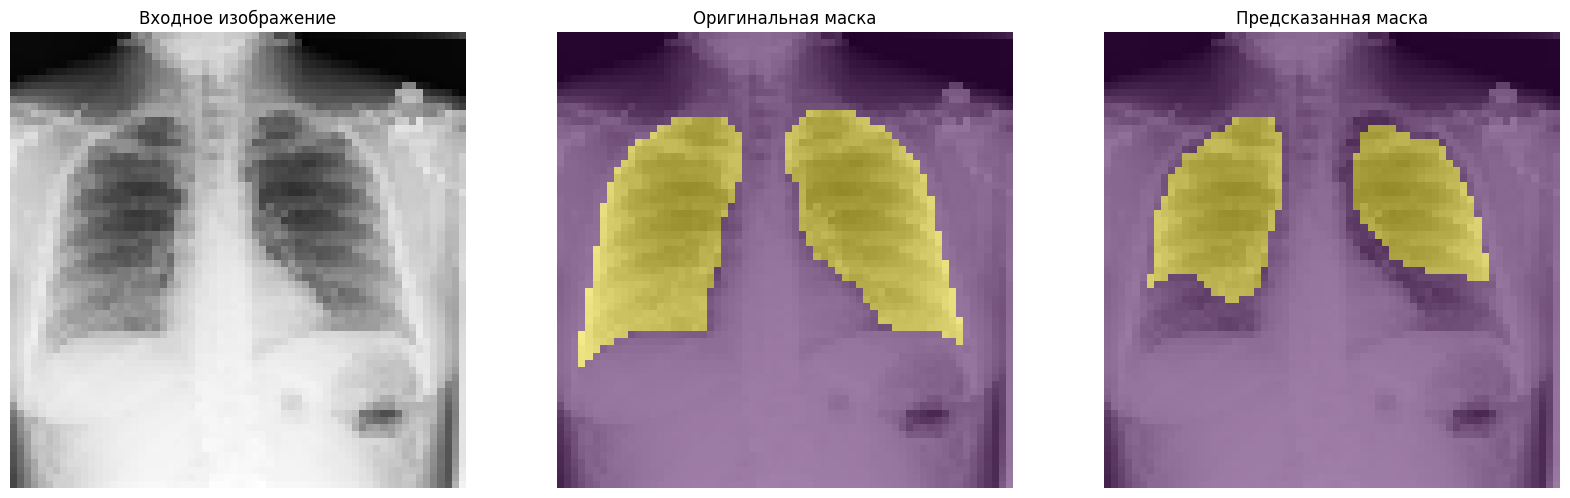

1/1 [==============================] - 0s 117ms/step


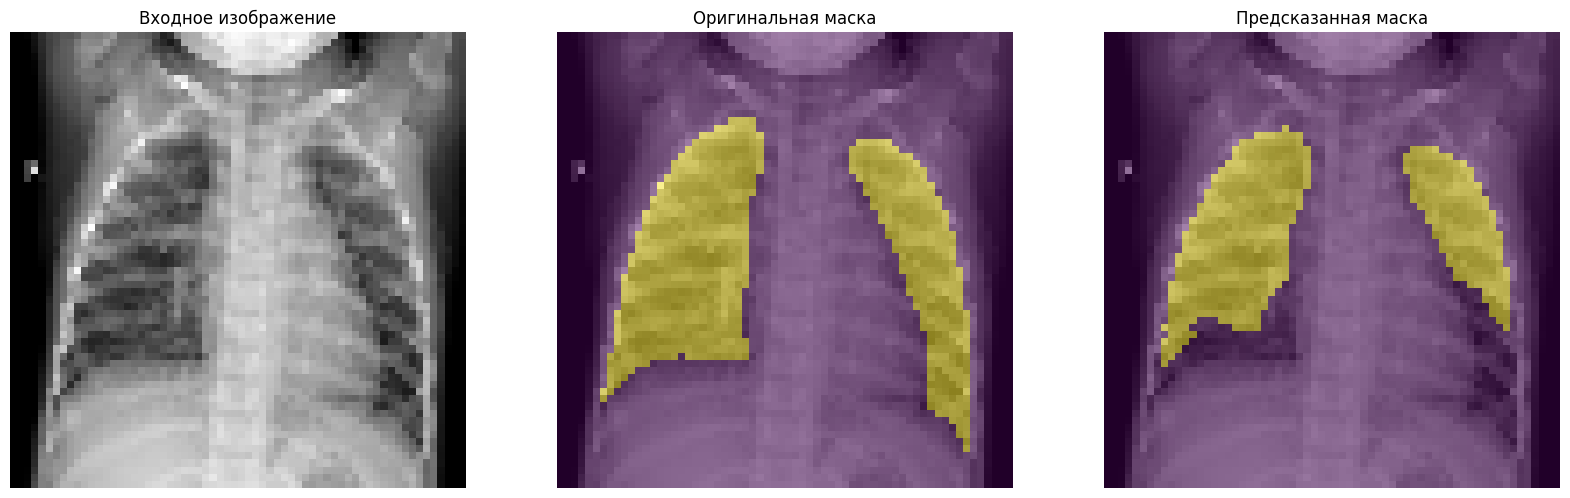

1/1 [==============================] - 0s 114ms/step


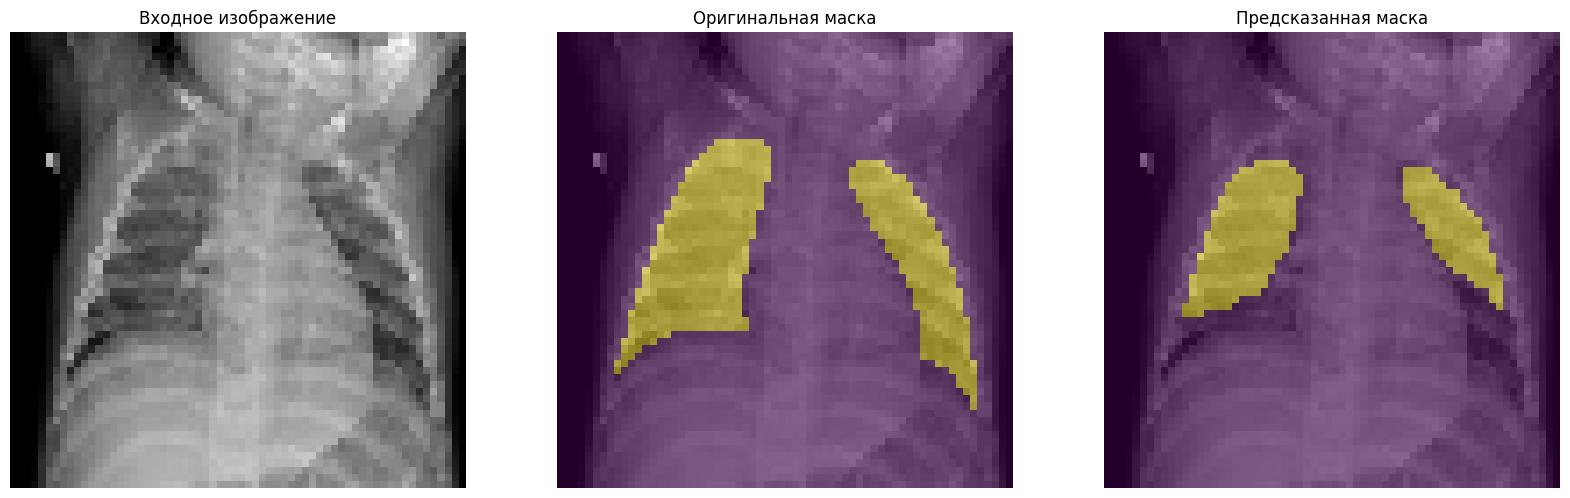

1/1 [==============================] - 0s 112ms/step


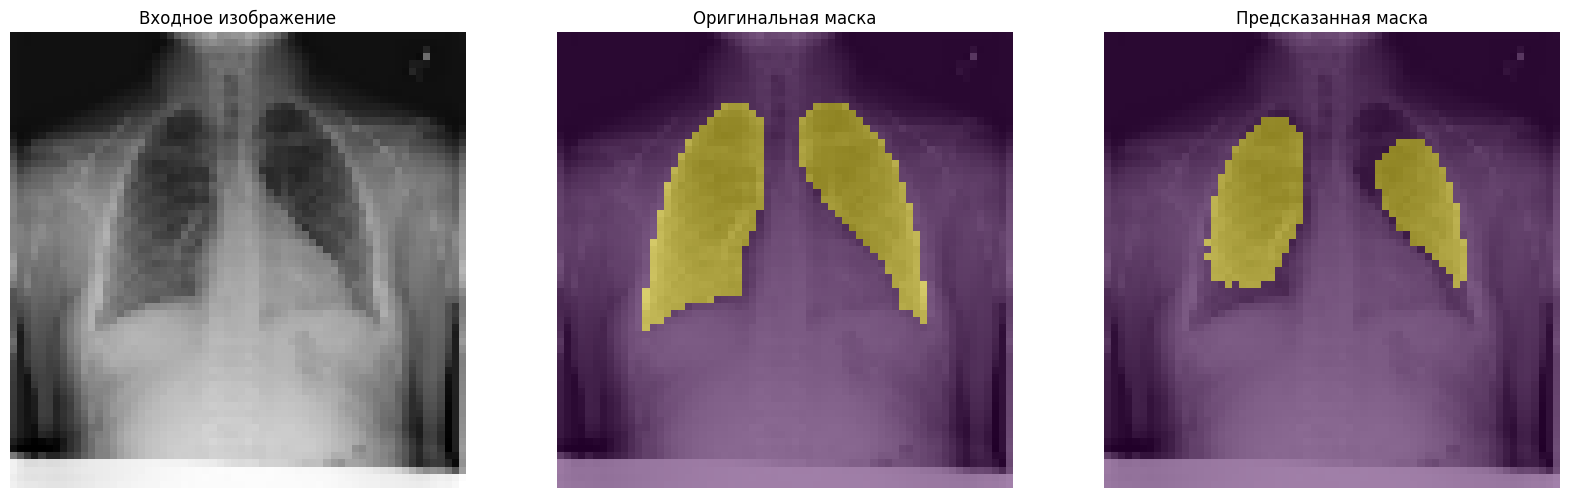

1/1 [==============================] - 0s 106ms/step


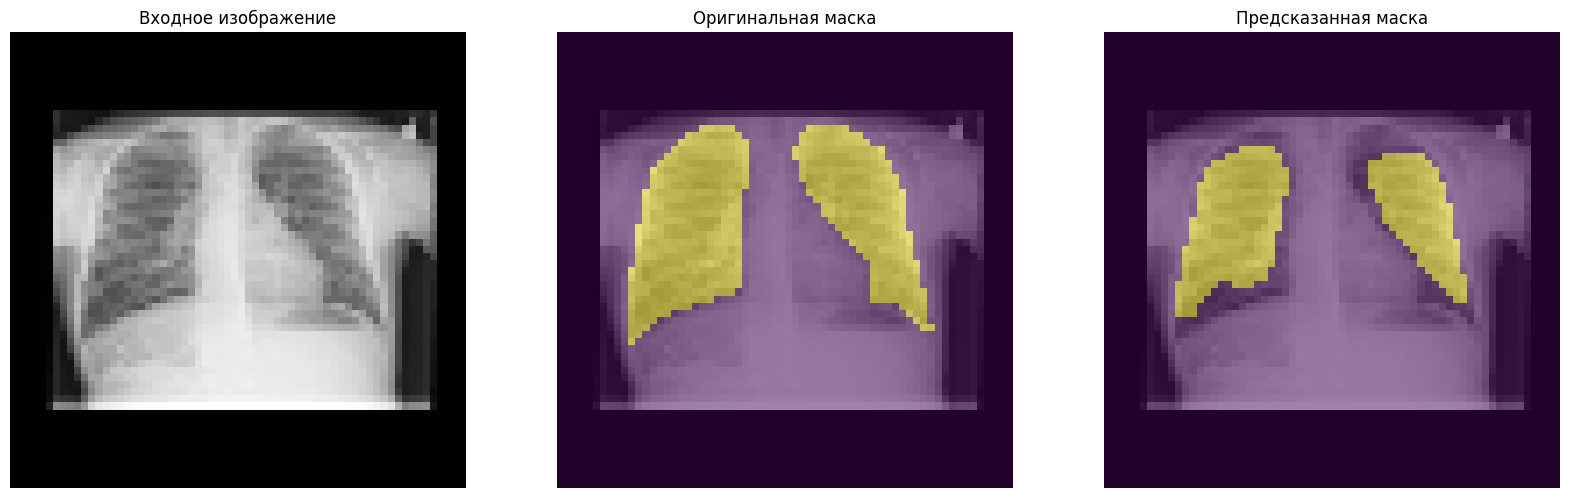

1/1 [==============================] - 0s 105ms/step


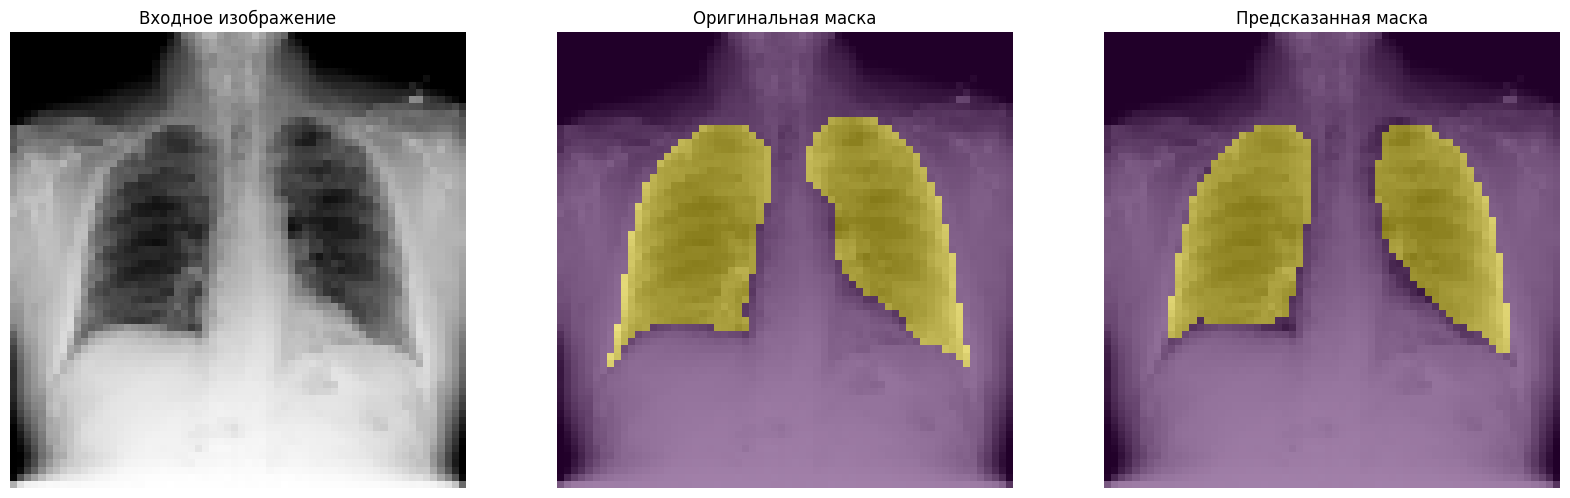

1/1 [==============================] - 0s 109ms/step


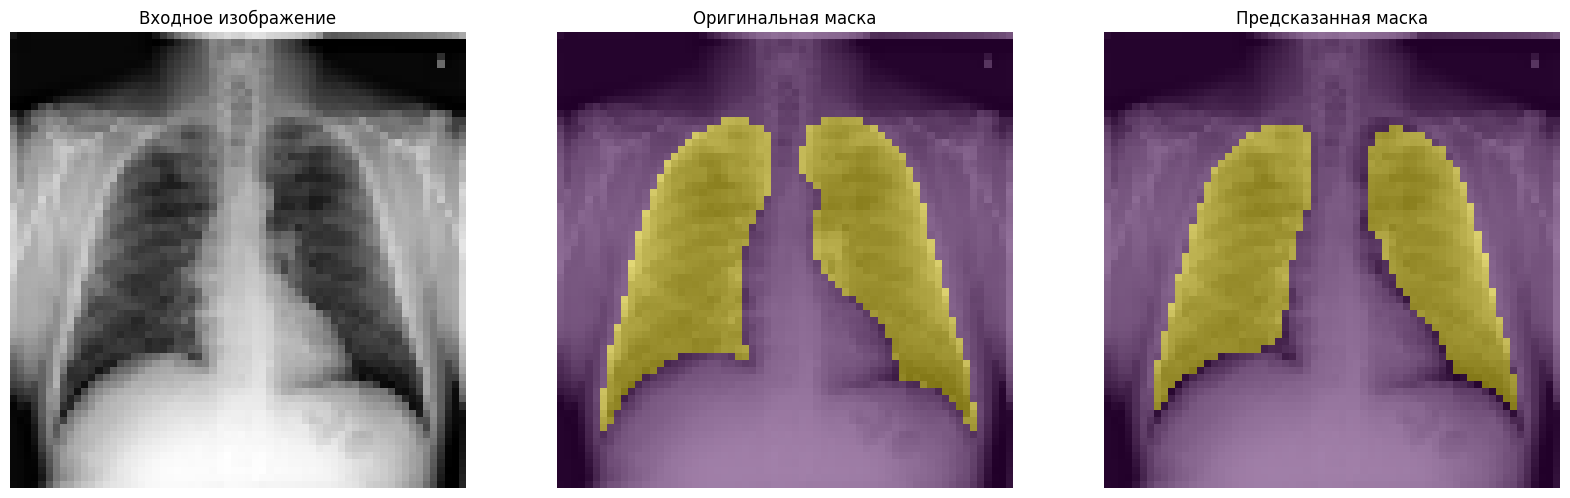

1/1 [==============================] - 0s 106ms/step


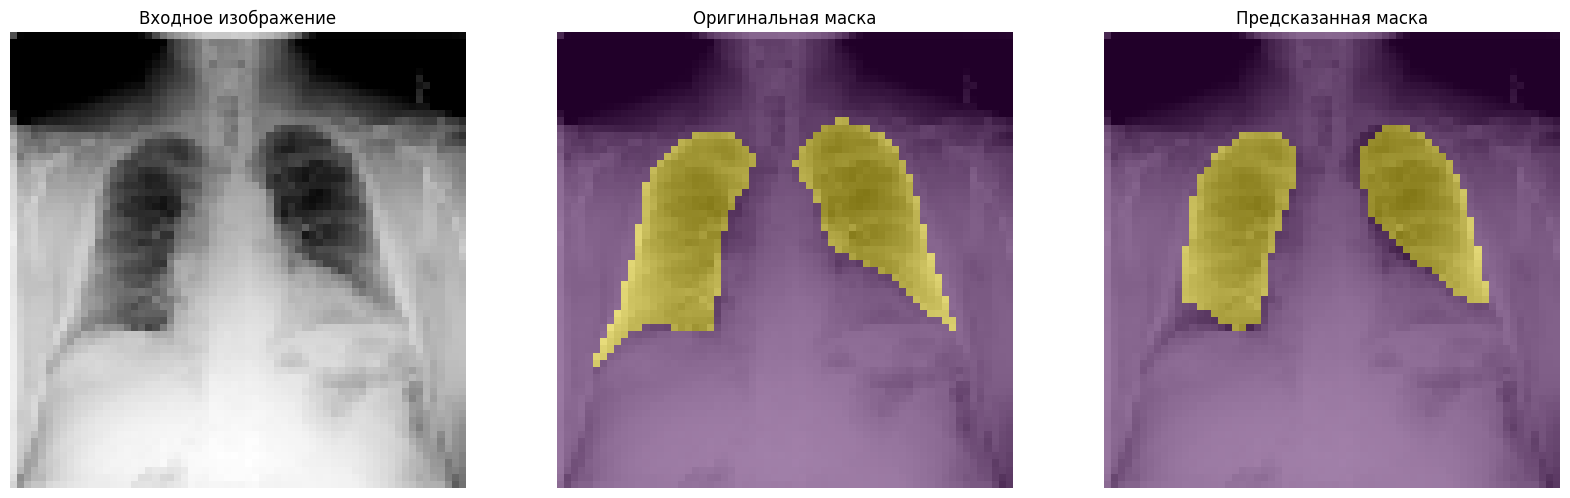

1/1 [==============================] - 0s 109ms/step


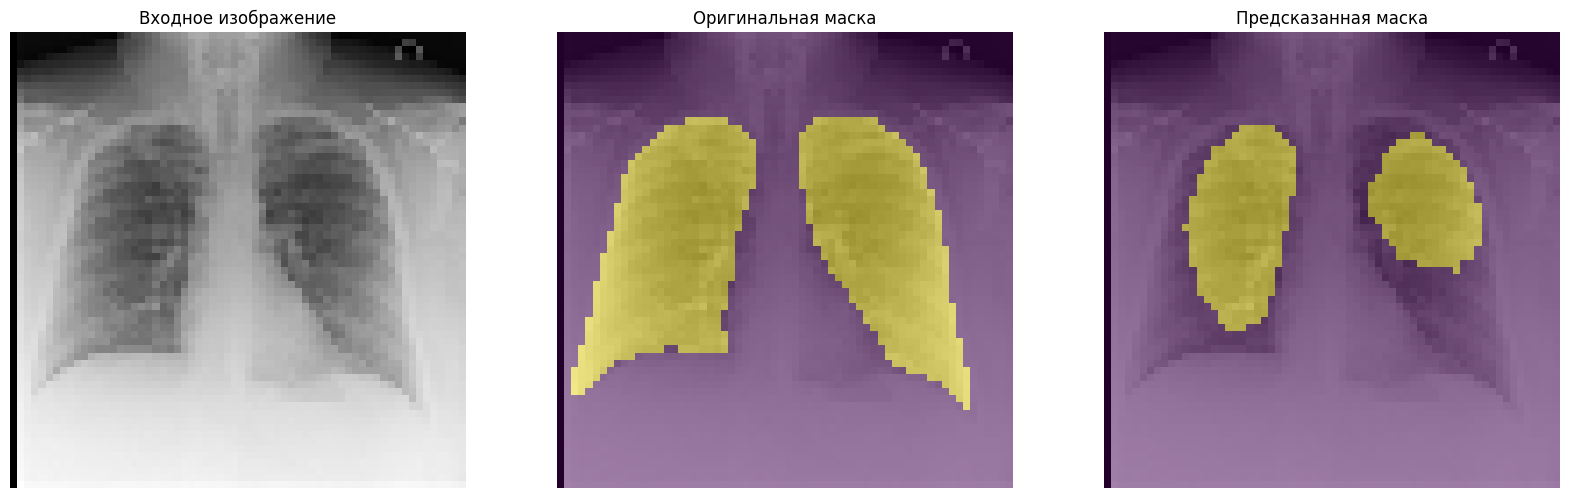

1/1 [==============================] - 0s 104ms/step


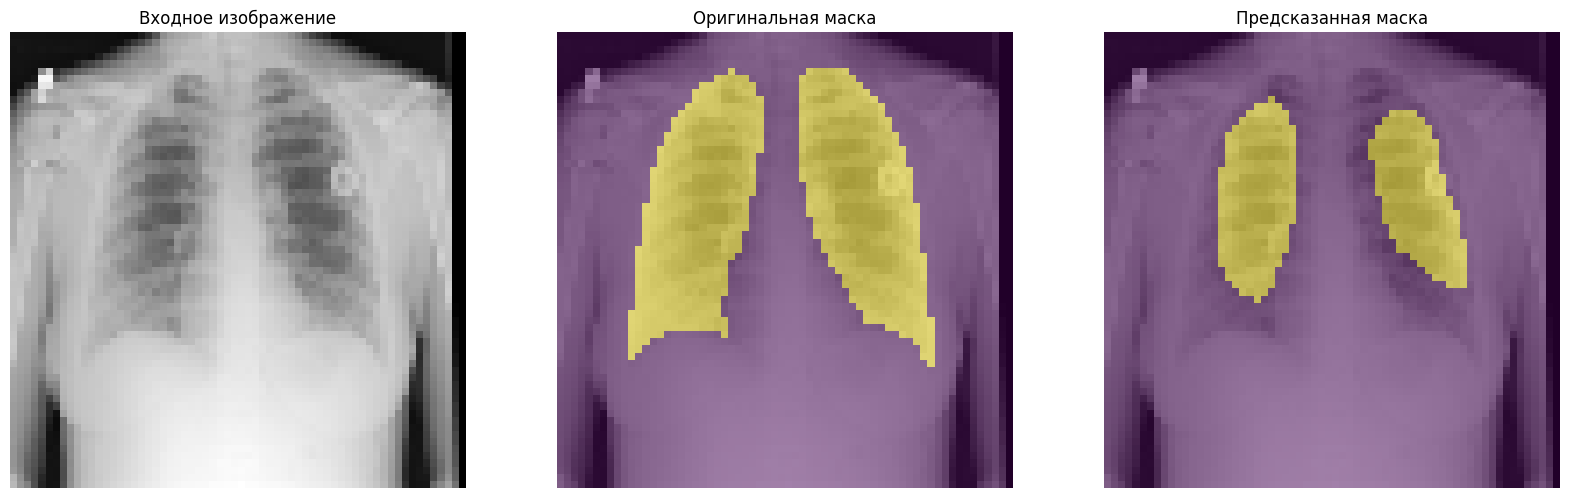

In [ ]:
def create_mask(pred_mask):

    pred_mask = tf.math.argmax(pred_mask, axis=-1)        # индекс аргумента с максимальным значением, вместо вероятности по классам получаем
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


for image, mask in test_dataset.take(10):                  # выбираем 10 картинок и выводим их в цикле

    pred_mask = model.predict(image[:1])                  # предсказываем маску с помощью обученной модели
    display([image[0], mask[0], create_mask(pred_mask)])  # передаем в функцию display изображение, оригинальную маску и предсказанную

# **Что ж, достичь нужного результата удалось, однако точность предсказанных сегментов не везде схожа на 100% с оригинальными, тем не менее, можно законтрить увеличением размерности изначальных файлов, но опять же, обучение слишком долгое. Пришлось выбирать средний результат**